In [1]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain.chains import ConversationalRetrievalChain, LLMChain
from langchain.chains.conversational_retrieval.prompts import CONDENSE_QUESTION_PROMPT, QA_PROMPT
from langchain.chains.question_answering import load_qa_chain
from langchain.memory import ConversationBufferMemory
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda
from langchain.schema.runnable.passthrough import RunnableAssign
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import ConversationChain

import re
from typing import List, Union
import requests
import os
from bs4 import BeautifulSoup
import base64
import matplotlib.pyplot as plt
import numpy as np


In [2]:
os.environ["NVIDIA_API_KEY"] = ""

# RAG LLM in Coding

## HTML document loader

In [3]:
def html_document_loader(url: Union[str, bytes]) -> str:
    """
    Loads the HTML content of a document from a given URL and return it's content.

    Args:
        url: The URL of the document.

    Returns:
        The content of the document.

    Raises:
        Exception: If there is an error while making the HTTP request.

    """
    try:
        response = requests.get(url)
        html_content = response.text
    except Exception as e:
        print(f"Failed to load {url} due to exception {e}")
        return ""

    try:
        # create Beautiful Soup obj to parse html
        soup = BeautifulSoup(html_content, "html.parser")

        # del script and style
        for script in soup(["script", "style"]):
            script.extract()

        # get pure text from html
        text = soup.get_text()

        # sub backspace
        text = re.sub("\s+", " ", text).strip()

        return text
    except Exception as e:
        print(f"Exception {e} while loading document")
        return ""

## Create embeddings from HTML

In [4]:
def index_docs(embeddings, url: Union[str, bytes], splitter, documents: List[str], dest_embed_dir) -> None:
    """
    Split the document into chunks and create embeddings for the document

    Args:
        embeddings: embedding model
        url: Source url for the document.
        splitter: Splitter used to split the document
        documents: list of documents whose embeddings needs to be created
        dest_embed_dir: destination directory for embeddings

    Returns:
        None
    """
    
    for document in documents:
        texts = splitter.split_text(document.page_content)

        # construct metadata by splitted url documents
        metadatas = [document.metadata]

        # create embedding and store them by FAISS
        if os.path.exists(dest_embed_dir):
            update = FAISS.load_local(folder_path=dest_embed_dir, embeddings=embeddings, allow_dangerous_deserialization=True)
            update.add_texts(texts, metadatas=metadatas)
            update.save_local(folder_path=dest_embed_dir)
        else:
            docsearch = FAISS.from_texts(texts, embedding=embeddings, metadatas=metadatas)
            docsearch.save_local(folder_path=dest_embed_dir)

In [5]:
def create_embeddings(embedding_model: str = "NV-Embed-QA", embedding_path: str = "./embed/"):
    print(f"Using embedding model: {embedding_model}")
    print(f"Storing embeddings to {embedding_path}")
    
    embeddings = NVIDIAEmbeddings(model=embedding_model)

    # html urls
    urls = [
         "https://docs.nvidia.com/nemo-framework/user-guide/latest/nemotoolkit/",
    ]

    # use `html_document_loader` to load html documents
    documents = []
    for url in urls:
        document = html_document_loader(url)
        documents.append(document)

    # define text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=0,
        length_function=len,
    )
    
    texts = text_splitter.create_documents(documents)

    index_docs(embeddings, url, text_splitter, texts, embedding_path)
    
    print("Generated embedding successfully")

In [6]:
def load_embed(embedding_model: str = "NV-Embed-QA", embedding_path: str = "./embed/"):
    return FAISS.load_local(folder_path=embedding_path, embeddings=NVIDIAEmbeddings(model=embedding_model), allow_dangerous_deserialization=True)

## Construct Chain

In [7]:
embedding_model = "NV-Embed-QA"
embedding_path = "./embed/"

create_embeddings(embedding_model, embedding_path)

Using embedding model: NV-Embed-QA
Storing embeddings to ./embed/
Generated embedding successfully


In [8]:
docsearch = load_embed(embedding_model, embedding_path)

llm = ChatNVIDIA(model="microsoft/phi-3-small-128k-instruct")

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

question_generator = LLMChain(llm=llm, prompt=CONDENSE_QUESTION_PROMPT)

chat = ChatNVIDIA(model="microsoft/phi-3-small-128k-instruct", temperature=0.1, max_tokens=1000, top_p=1.0)

doc_chain = load_qa_chain(chat , chain_type="stuff", prompt=QA_PROMPT)

/home/nvidia/.local/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/home/nvidia/.local/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: This class is deprecated. See the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/v0.2/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: https://python.langchain.com/v0.2/docs/versions/migrating_chains/map_reduce_chain
refine: https://python.langchain.com/v0.2/docs/versions/migrating_chains/refine_chain
map_rerank: https://python.langchain.com/v0.2/docs/versions/migrating_chains/map_rerank_docs_chain

See also guides on retrieval and question-answering here: https://python.langchain.com/v0.2/docs/how_to/#qa-with-rag
  warn_deprecated(


In [9]:
qa = ConversationalRetrievalChain(
    retriever=docsearch.as_retriever(),
    combine_docs_chain=doc_chain,
    memory=memory,
    question_generator=question_generator,
)

/home/nvidia/.local/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `ConversationalRetrievalChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use create_history_aware_retriever together with create_retrieval_chain (see example in docstring) instead.
  warn_deprecated(


## Chat with Agent

In [10]:
def agent(query: str):
    result = qa({"question": query})
    rag_result = result.get("answer")
    print(rag_result)

In [11]:
query = "Give me a 'hello world'-style example using CUDA C++ code."

agent(query)

/home/nvidia/.local/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


 ```cpp
  #include <iostream>
  #include <cuda_runtime.h>

  __global__ void helloWorldKernel() {
      std::cout << "Hello World from CUDA!" << std::endl;
  }

  int main() {
      helloWorldKernel<<<1, 1>>>();
      cudaDeviceSynchronize();
      return 0;
  }
  ```
  This CUDA C++ code defines a simple kernel function `helloWorldKernel` that prints "Hello World from CUDA!" to the console. The kernel is launched with a single thread block containing one thread. The `cudaDeviceSynchronize()` call ensures that the host waits for the kernel to finish execution before exiting the program.


# Vision-Language Model in Coding

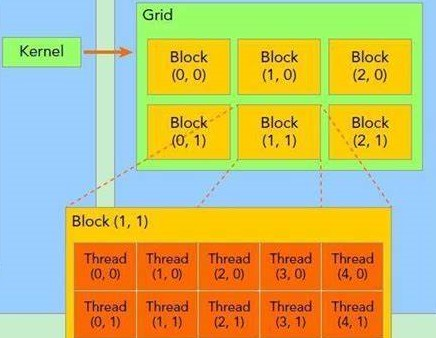

In [12]:
from PIL import Image
img_path = "./data/kernel_size.jpg"
display(Image.open(img_path))

In [13]:
def image2b64(image_file):
    with open(image_file, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
        return image_b64

def vl_agent(img_path, user_input):

    image_b64 = image2b64(img_path)
    # Chart reading Runnable
    chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
    chart_reading_prompt = ChatPromptTemplate.from_template(
        'What is the grid size and block size in the figure below, : <img src="data:image/png;base64,{image_b64}" /> '
    )
    chart_chain = chart_reading_prompt | chart_reading

    # Instruct LLM Runnable
    # instruct_chat = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")
    instruct_chat = ChatNVIDIA(model="microsoft/phi-3-small-128k-instruct")

    
    instruct_prompt = ChatPromptTemplate.from_template(
        "Based on the description: {image_info}, {input}"
    )

    instruct_chain = instruct_prompt | instruct_chat

    chart_reading_branch = RunnableBranch(
        (lambda x: x.get('image_info') is None, RunnableAssign({'image_info': chart_chain})),
        (lambda x: x.get('image_info') is not None, lambda x: x),
        lambda x: x
    )
    
    chain = (
        chart_reading_branch
        | (lambda x: {'image_info': x.get('image_info').content, 'input': user_input})
        | instruct_chain
    )

    return chain.invoke({"image_b64": image_b64, "input": user_input}).content

In [14]:
user_input = "Generate a hello world-style example using CUDA C++ code"

result = vl_agent(img_path, user_input)
print(result)

 ```cpp

  #include <stdio.h>

  #include <cuda.h>

  #include <curand.h>

  #include <curand_kernel.h>


  // Define the block size

  #define BLOCK_SIZE 2


  __global__ void helloWorldKernel(int *deviceMessage) {

      // Calculate the global thread ID

      int threadId = blockIdx.x * blockDim.x + threadIdx.x;

      // Write the message to the device memory

      deviceMessage[threadId] = threadId;

  }


  int main() {

      // Message to be printed

      const char *message = "Hello World!";


      // Allocate memory on the device

      int *deviceMessage;

      cudaMalloc((void **)&deviceMessage, BLOCK_SIZE * sizeof(int));


      // Copy the message to the device memory

      cudaMemcpy(deviceMessage, message, strlen(message) + 1, cudaMemcpyHostToDevice);


      // Launch the kernel

      int blockSize = BLOCK_SIZE;

      int gridSize = (BLOCK_SIZE + 2 - 1) / 2; // 3

      helloWorldKernel<<<gridSize, blockSize>>>(deviceMessage);


      // Copy the result back to

In [ ]:
import gradio as gr
multi_modal_chart_agent = gr.Interface(fn=vl_agent,
                    inputs=[gr.Image(label="Upload image", type="filepath"), 'text'],
                    outputs=['text'],
                    title="Multi Modal chat agent",
                    description="Multi Modal chat agent",
                    allow_flagging="never")

multi_modal_chart_agent.launch(debug=True, share=False, show_api=False, server_port=5000, server_name="0.0.0.0")

Running on local URL:  http://0.0.0.0:5000

To create a public link, set `share=True` in `launch()`.
